# Contour plots of tracer concentration on shelf bottom without canyon lid

Map hcw on shelf by looking at bottom cells and multiplying their concentration by their area.


The algorithm:

In [1]:
#KRM

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

import matplotlib.cm as cm

import matplotlib as mpl

from math import *

from mpl_toolkits.mplot3d.axes3d import Axes3D

import scipy.io

import scipy as spy

%matplotlib inline

from netCDF4 import Dataset

import pylab as pl

import os 

import sys

import seaborn as sns


In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 


In [3]:
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [4]:
#Base case, iso =1 , No 3d diff.
#CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

NoCCanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'
NoCCanyonGridOut = Dataset(NoCCanyonGrid)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

Ptracer='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/ptracersGlob.nc'
PtracerOut = Dataset(Ptracer)

Ptracer07='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/ptracersGlob.nc'
PtracerOut07 = Dataset(Ptracer07)

Ptracer14='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run14/ptracersGlob.nc'
PtracerOut15 = Dataset(Ptracer14)

Ptracer15='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run15/ptracersGlob.nc'
PtracerOut15 = Dataset(Ptracer15)

Ptracer26='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run26/ptracersGlob.nc'
PtracerOut26 = Dataset(Ptracer26)

Ptracer27='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run27/ptracersGlob.nc'
PtracerOut27 = Dataset(Ptracer27)

Ptracer18='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run18/ptracersGlob.nc'
PtracerOut18 = Dataset(Ptracer18)

Ptracer19='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run19/ptracersGlob.nc'
PtracerOut19 = Dataset(Ptracer19)

Ptracer22='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run22/ptracersGlob.nc'
PtracerOut22 = Dataset(Ptracer22)

Ptracer23='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run23/ptracersGlob.nc'
PtracerOut23 = Dataset(Ptracer23)


In [5]:
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
bathy = rout.getField(CanyonGrid, 'Depth')
bathyNoC = rout.getField(NoCCanyonGrid, 'Depth')

hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

hFacCNoC = rout.getField(NoCCanyonGrid, 'HFacC')
MaskCNoC = rout.getMask(NoCCanyonGrid, 'HFacC')
rANoC = rout.getField(NoCCanyonGrid, 'rA')
rA = rout.getField(CanyonGrid, 'rA')

z = CanyonStateOut.variables['Z']

time = CanyonStateOut.variables['T']

In [6]:
Tr03 = rout.getField(Ptracer,'Tr1') 
Tr07 = rout.getField(Ptracer07,'Tr1') 

In [7]:
Tr14 = rout.getField(Ptracer14,'Tr1') 
Tr26 = rout.getField(Ptracer26,'Tr1') 

In [8]:
Tr15 = rout.getField(Ptracer15,'Tr1') 
Tr27 = rout.getField(Ptracer27,'Tr1') 

In [9]:
Tr18 = rout.getField(Ptracer18,'Tr1')  
Tr22 = rout.getField(Ptracer22,'Tr1') 

In [10]:
Tr19 = rout.getField(Ptracer19,'Tr1') 
Tr23 = rout.getField(Ptracer23,'Tr1') 

In [11]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcArea(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((19,360,360))
    Conc = np.empty((19,360,360))
    Area = np.empty((360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis

    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for i in range(360):
            for j in range(360):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                ConcArea[tt,i,j] = TrBottom*ra[i,j]
                Conc[tt,i,j] = TrBottom
                Area[i,j] = ra[i,j]
    
    print(np.shape(ConcArea))
    
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    

    #ConcAreaMasked = np.ma.masked_values(ConcDepths,-2.5)
    #ConcDepths[np.where(np.ma.getmask(ConcDepthsMasked)==True)] = np.nan

    return (ConcArea,np.ma.masked_array(Conc, mask=maskShelf), Area)

In [12]:
ConcArea03,Conc03,Area03=ConcArea(Tr03, hFacC, rA, bathy)
ConcArea07,Conc07,Area07=ConcArea(Tr07, hFacCNoC, rANoC, bathyNoC)
ConcArea14,Conc14,Area14=ConcArea(Tr14, hFacC, rA, bathy)
ConcArea15,Conc15,Area15=ConcArea(Tr15, hFacC, rA, bathy)
ConcArea18,Conc18,Area18=ConcArea(Tr18, hFacC, rA, bathy)
ConcArea19,Conc19,Area19=ConcArea(Tr19, hFacC, rA, bathy)
ConcArea26,Conc26,Area26=ConcArea(Tr26, hFacCNoC, rANoC, bathyNoC)
ConcArea27,Conc27,Area27=ConcArea(Tr27, hFacCNoC, rANoC, bathyNoC)
ConcArea22,Conc22,Area22=ConcArea(Tr22, hFacCNoC, rANoC, bathyNoC)
ConcArea23,Conc23,Area23=ConcArea(Tr23, hFacCNoC, rANoC, bathyNoC)

(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


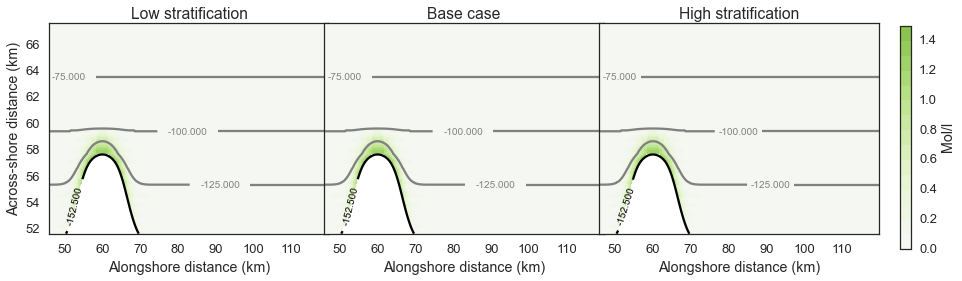

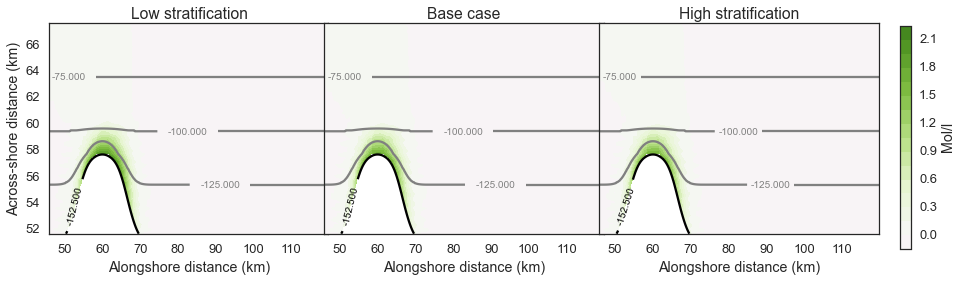

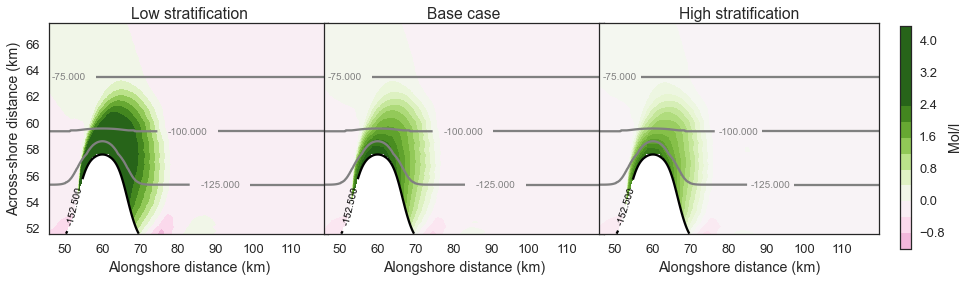

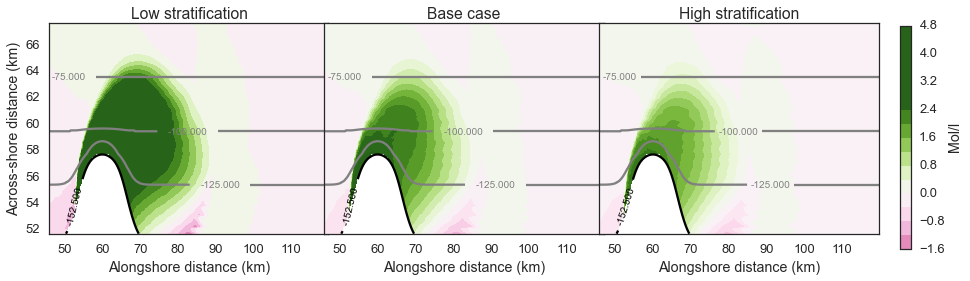

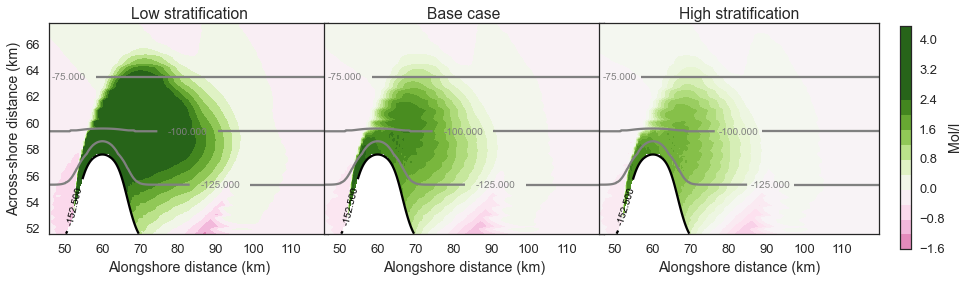

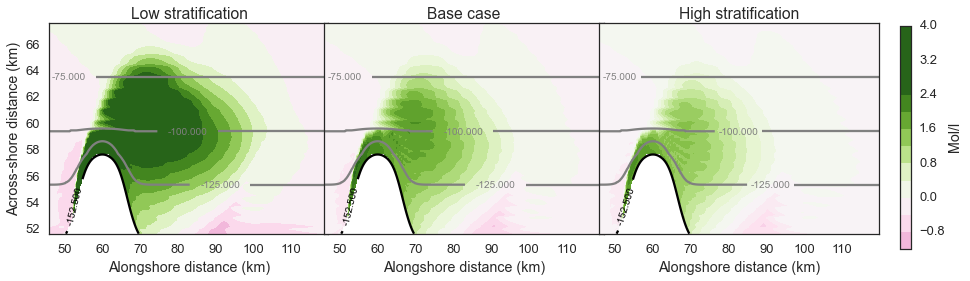

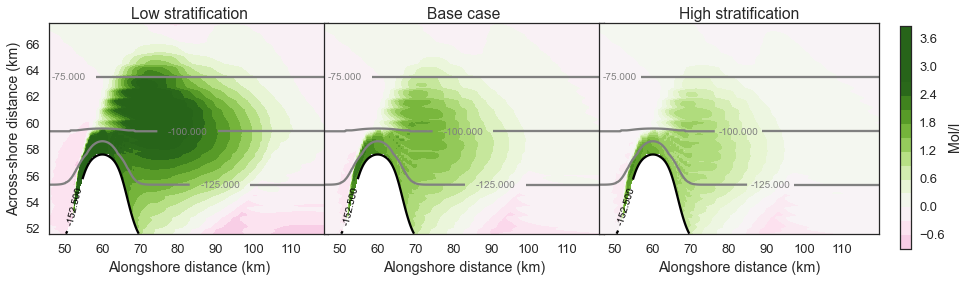

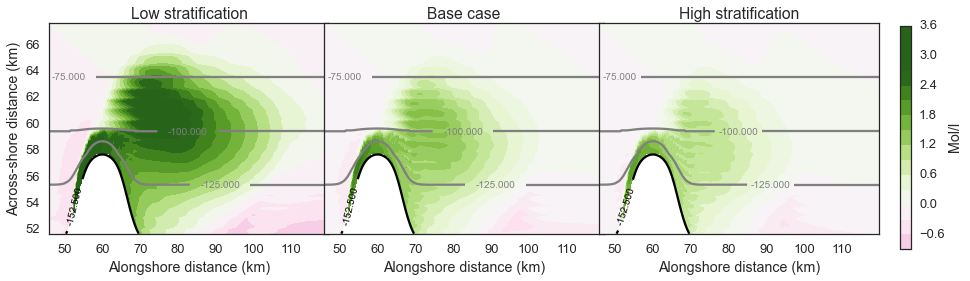

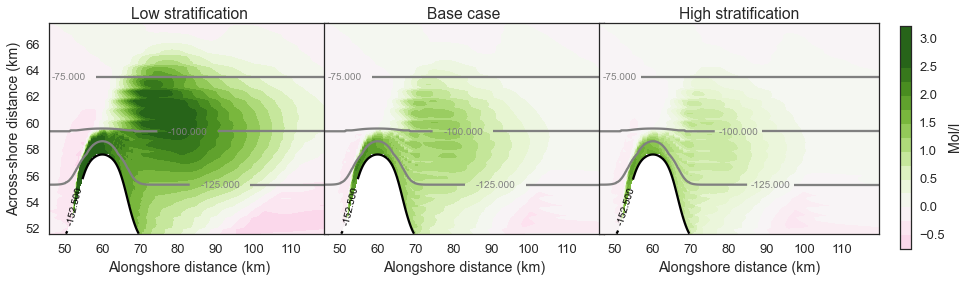

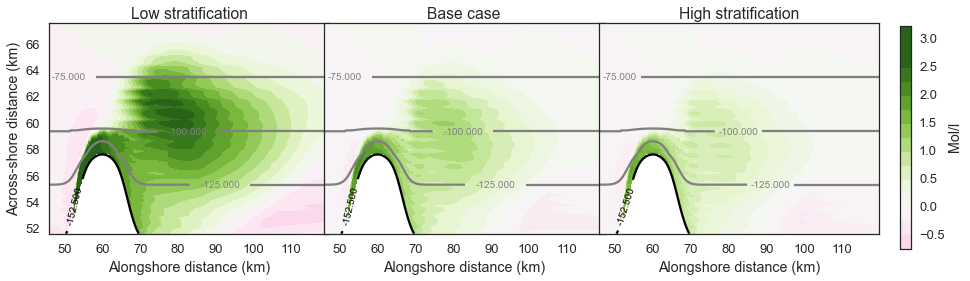

In [13]:
sns.set_context('talk', font_scale=1.0)

for tt in np.arange(0,19,2):
    
    fig,((ax1),(ax2),(ax3)) = plt.subplots(1, 3, figsize=(16, 4),  sharey=True, sharex=True)
    
    iso = ax1.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,Conc14[tt,227:300,100:]-Conc26[tt,227:300,100:],
                       15, vmax=2.6, vmin=-2.6,cmap='PiYG')
    cset = ax1.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,-bathy[227:300,100:],[rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],linewidth=1, rstride=2, cstride=2,zdir='z')
    ax1.clabel(cset, inline=1, fontsize=10)
    
    ax1.set_aspect('auto')
    ax1.set_title('Low stratification')
    ax1.set_ylabel('Across-shore distance (km)')
    ax1.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso2 = ax2.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        Conc03[tt,227:300,100:]-Conc07[tt,227:300,100:],15,vmax=2.6, vmin=-2.6,cmap='PiYG')
    
    cset = ax2.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,-bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50], colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z')
    ax3.clabel(cset, inline=1, fontsize=10)
    
    ax2.set_aspect('auto')
    ax2.set_title('Base case')
    ax2.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso3 = ax3.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        Conc15[tt,227:300,100:]-Conc27[tt,227:300,100:],15, vmax=2.6, vmin=-2.6,cmap='PiYG')
    cax,kw = mpl.colorbar.make_axes([ax1,ax2,ax3],location='right',shrink=1, pad = -0.44)
    cb = plt.colorbar(iso, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax3.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,-bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z')
    ax3.clabel(cset, inline=1, fontsize=10)
    ax3.set_aspect('auto')
    ax3.set_title('High stratification ' %(tt/2.0))
    ax3.set_xlabel('Alongshore distance (km)')
    
    plt.tight_layout()
    plt.show

#fig.savefig('/ocean/kramosmu/Figures/BathyShelfBoxComplete.eps', format='eps', dpi=1000, bbox_inches='tight')

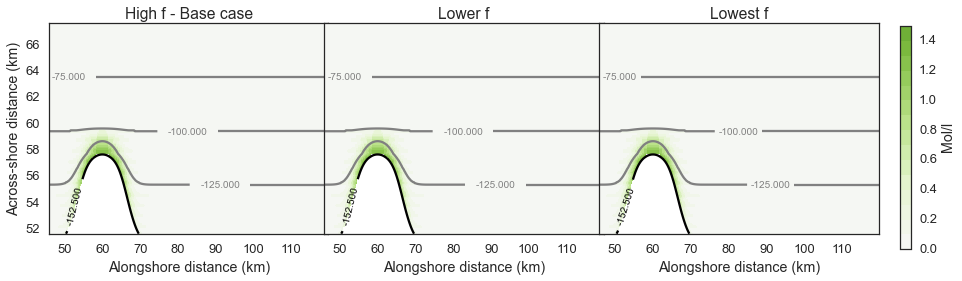

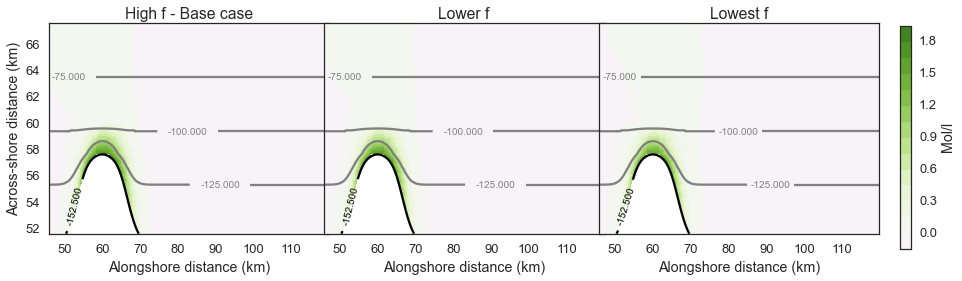

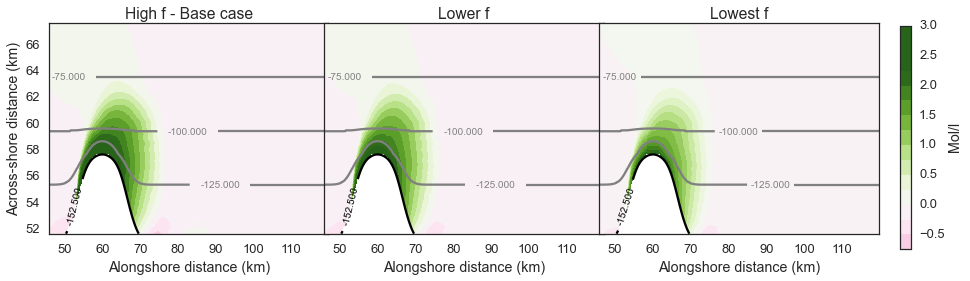

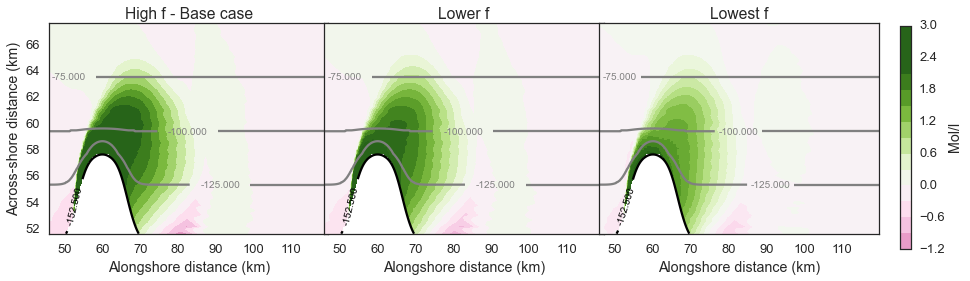

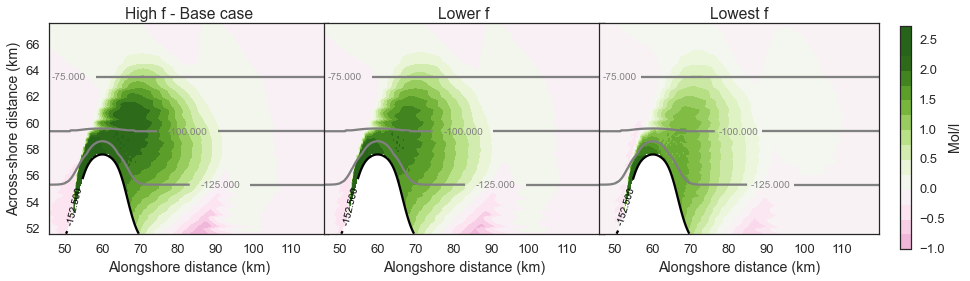

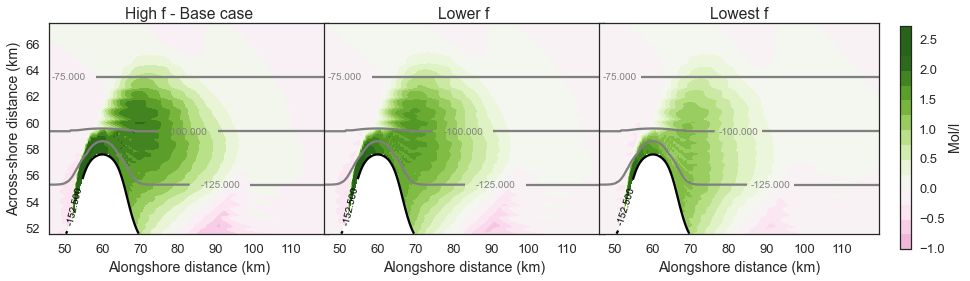

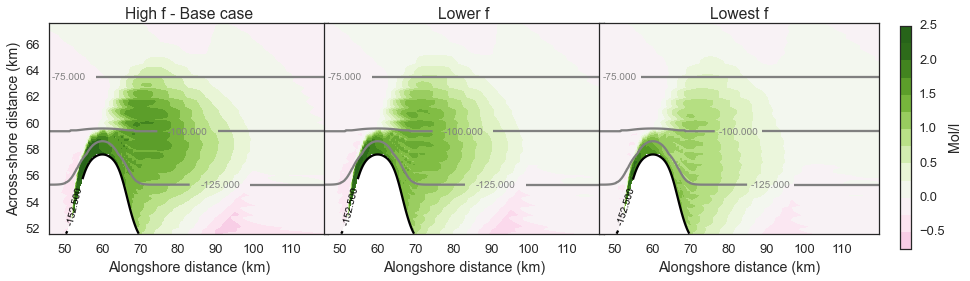

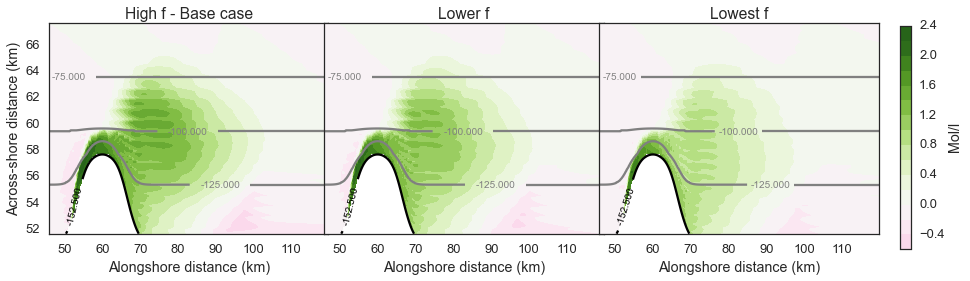

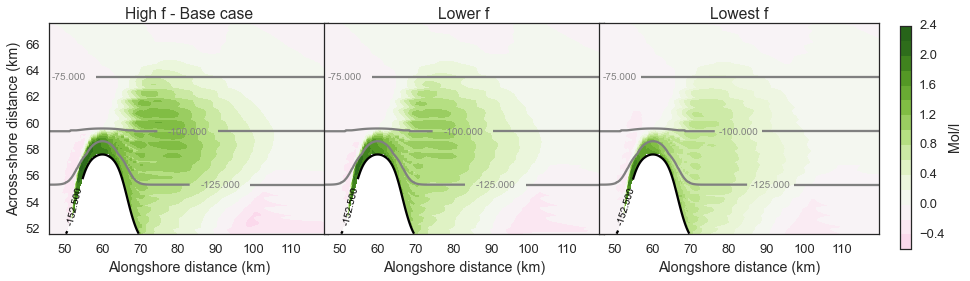

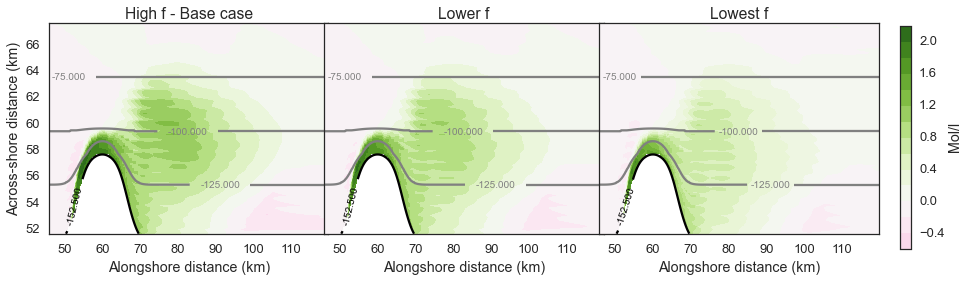

In [14]:
sns.set_context('talk', font_scale=1.0)

for tt in np.arange(0,19,2):
    
    fig,((ax1),(ax2),(ax3)) = plt.subplots(1, 3, figsize=(16, 4),  sharey=True, sharex=True)
    
    iso = ax1.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,Conc03[tt,227:300,100:]-Conc07[tt,227:300,100:],
                       15, vmax=2.2, vmin=-2.2,cmap='PiYG')
    cset = ax1.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,-bathy[227:300,100:],[rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],linewidth=1, rstride=2, cstride=2,zdir='z')
    ax1.clabel(cset, inline=1, fontsize=10)
    
    ax1.set_aspect('auto')
    ax1.set_title('High f - Base case')
    ax1.set_ylabel('Across-shore distance (km)')
    ax1.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso2 = ax2.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        Conc18[tt,227:300,100:]-Conc22[tt,227:300,100:],15,vmax=2.2, vmin=-2.2,cmap='PiYG')
    
    cset = ax2.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,-bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50], colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z')
    ax2.clabel(cset, inline=1, fontsize=10)
    
    ax2.set_aspect('auto')
    ax2.set_title('Lower f')
    ax2.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso3 = ax3.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        Conc19[tt,227:300,100:]-Conc23[tt,227:300,100:],15, vmax=2.2, vmin=-2.2,cmap='PiYG')
    cax,kw = mpl.colorbar.make_axes([ax1,ax2,ax3],location='right',shrink=1, pad = -0.44)
    cb = plt.colorbar(iso, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax3.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,-bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z')
    ax3.clabel(cset, inline=1, fontsize=10)
    
    ax3.set_aspect('auto')
    ax3.set_title('Lowest f ' %(tt/2.0))
    ax3.set_xlabel('Alongshore distance (km)')
    
    plt.tight_layout()
    plt.show

#fig.savefig('/ocean/kramosmu/Figures/BathyShelfBoxComplete.eps', format='eps', dpi=1000, bbox_inches='tight')